In [1]:
%matplotlib inline

In [2]:
## Boiler plate code common to many notebooks.  See the TestFilesCommonCode.ipynb for details
from __future__ import print_function
%run TestFilesCommonCode.ipynb

SimpleITK Version: 0.9.1
Compiled: Sep 28 2015 10:07:41



In [3]:
import nibabel as nib
import dipy.io
import scipy.io # for writing the .mat files
import numpy as np

In [4]:
# 
# READ input DWI scan using pynrrd
#
import nrrd

class nrrdDWIHeader:
    """A helper class for manipulating header information
    from a nrrd DWI data set into a nibabel compliant
    format"""
    def __init__(self,pynrrdDataModel):
        self.modality=None                      #Matches NRRD File
        self.global_BValue=None                 #Matches NRRD File
        self.gradientUnormalizedVectors=[None]  #Matches NRRD File

        self.gradientIndex=-1
        self.gradientBValues=[None]             #Computed
        self.gradientVectors=[None]             #Computed
        self._ConvertNrrdToNibabelDWIDataModel(pynrrdDataModel)

    def Print(self):
        print("global_BValue {0}".format(self.global_BValue) )
        print("modality {0}".format(self.modality) )
        print("gradientBValues {0}".format(self.gradientBValues) )
        print("gradientDirections {0}".format(self.gradientUnormalizedVectors) )

    def _getGradientStorageIndex(self,pynrrdDataModel):
        """The 4D index that has separate gradients.
        all other directions are the spatial dimensions."""
        gradient_index=-1;
        centerings=pynrrdDataModel['centerings']
        numdwidims=len(centerings)
        for test_index in range(0,numdwidims):
            if centerings[test_index] not in ['cell']:
                gradient_index=test_index
        self.gradientIndex = gradient_index

    def _ExtractGlobalBValue(self, pyNrrdKVUnknownMetaData):
        globalBValueString=pyNrrdKVUnknownMetaData.get(u'DWMRI_b-value','0').lstrip().rstrip()
        self.global_BValue=float( globalBValueString )

    def _ExtractUnormalizedBValues(self,pyNrrdKVUnknownMetaData,pynrrdDataModel):
        """Unnormalized data values from the nrrd files, where the
        magnitude is reflective of the scale relative to the global_BValue"""
        self._getGradientStorageIndex(pynrrdDataModel)
        numGradients = pynrrdDataModel[u'sizes'][self.gradientIndex]
        self.gradientUnormalizedVectors= np.array( [ [ None, None, None ] for x in range(0,numGradients) ] )
        gvec_Fields=pyNrrdKVUnknownMetaData.copy() #Clone so we can remove items
        for k,v in gvec_Fields.iteritems():
            if k.startswith("DWMRI_gradient_"):
                index=int(k.split('_')[2])
                self.gradientUnormalizedVectors[index,:]=np.array([ float(x) for x in v.rstrip().lstrip().split() ],
                                                    copy=True, order='C', ndmin=1)
                pyNrrdKVUnknownMetaData.pop(k)


    def _ExtractDWIModality(self,pyNrrdKVUnknownMetaData):
        self.modality=pyNrrdKVUnknownMetaData.get("modality","UNKNOWN").lstrip().rstrip()

    def _ComputeNormalizedBvecBVals(self,pyNrrdKVUnknownMetaData,pynrrdDataModel):
        self._ExtractGlobalBValue(pyNrrdKVUnknownMetaData)
        self._ExtractUnormalizedBValues(pyNrrdKVUnknownMetaData,pynrrdDataModel)
        self._ComputeNormalizedGradientsAndBValues()

    def _ComputeNormalizedGradientsAndBValues(self):
        """Following conventions of NRRD format, expand
        to normalized vectors and estimate BValues
        :return: void
        """
        numGradients=len( self.gradientUnormalizedVectors )

        self.gradientVectors = np.array(self.gradientUnormalizedVectors)
        self.gradientBValues = np.array( [ self.global_BValue ] * numGradients )
        for index in range(0,numGradients):
            gv = self.gradientUnormalizedVectors[index]
            norm=np.linalg.norm(gv)
            if norm < 1e-2:
                self.gradientVectors[index] = gv * 0.0
                self.gradientBValues[index] = 0.0
            elif ( abs( 1.0-norm ) > 1e-2 ): #Avoid B0 and need greater than 1e-2 from 1. for rescaling
                self.gradientVectors[index] = gv/norm
                self.gradientBValues[index] = self.global_BValue/norm

    def _ConvertNrrdToNibabelDWIDataModel(self, pynrrdDataModel):
        pyNrrdKVUnknownMetaData=pynrrdDataModel['keyvaluepairs']
        self._ExtractDWIModality(pyNrrdKVUnknownMetaData)
        self._ExtractGlobalBValue(pyNrrdKVUnknownMetaData)
        self._ComputeNormalizedBvecBVals(pyNrrdKVUnknownMetaData,pynrrdDataModel)

def ReadNAMICDWIFromNrrd(filename):
    nrrd_dwi_data,nrrd_dwi_header=nrrd.read(filename)
    nibabelDataModelDWI=nrrdDWIHeader(nrrd_dwi_header)
    nrrd_dwi_bvec=nibabelDataModelDWI.gradientVectors
    nrrd_dwi_bval=nibabelDataModelDWI.gradientBValues
    gradient_index=nibabelDataModelDWI.gradientIndex
    return (nrrd_dwi_data, nrrd_dwi_header, nrrd_dwi_bvec, nrrd_dwi_bval, gradient_index)

In [5]:
dwi_1='/Shared/johnsonhj/HDNI/20150319_DWIProcessing/Results/PHD_024/0029/34504/Outputs/DWI_Corrected_Aligned_CS.nrrd'
dwi_2='/Shared/johnsonhj/HDNI/20150319_DWIProcessing/Results/PHD_024/0029/83611/Outputs/DWI_Corrected_Aligned_CS.nrrd'

data1,dwi_header1,bvecs1,bvals1,gradient_index1 = ReadNAMICDWIFromNrrd(dwi_1)
data2,dwi_header2,bvecs2,bvals2,gradient_index2 = ReadNAMICDWIFromNrrd(dwi_2)

In [6]:
# Create TensorFit for scan 1
# (http://nipy.org/dipy/reference/dipy.reconst.html#dipy.reconst.dti.TensorFit)
# 
from dipy.core.gradients import gradient_table
gtab1 = gradient_table(bvals1, bvecs1)

from dipy.reconst.dti import TensorModel
ten1 = TensorModel(gtab1)
tenfit1 = ten1.fit(data1)

# Followings are only needed in displaying ODFs
from dipy.reconst.dti import fractional_anisotropy
fa1 = fractional_anisotropy(tenfit1.evals)
fa1[np.isnan(fa1)] = 0
fa1 = np.clip(fa1, 0, 1)

from dipy.reconst.dti import color_fa
cfa1 = color_fa(fa1, tenfit1.evecs)

In [7]:
# repeat for scan 2
#
gtab2 = gradient_table(bvals2, bvecs2)
ten2 = TensorModel(gtab2)
tenfit2 = ten2.fit(data2)

# Followings are only needed in displaying ODFs
fa2 = fractional_anisotropy(tenfit2.evals)
fa2[np.isnan(fa2)] = 0
fa2 = np.clip(fa2, 0, 1)
cfa2 = color_fa(fa2, tenfit2.evecs)

In [8]:
print(data1.shape)
print(data2.shape)

(128, 128, 70, 82)
(128, 128, 70, 82)


In [10]:
#
# http://nipy.org/dipy/reference/dipy.reconst.html#dipy.reconst.dti.TensorFit
#
# some tests
if(0):
    # see tensor values in position 0,0,0
    print(tenfit1[0,0,0].lower_triangular()) # or tenfit1.lower_triangular()[0,0,0]
    # see tensor eigenvalues in position 0
    print(tenfit1[0,0,0].evals) # or tenfit1.evals[0,0,0]
    # see tensor eigenvectors in position 0
    print(tenfit1[0,0,0].evecs) # or tenfit1.evecs[0,0,0]
    # see FA in position 0
    print(tenfit1[0,0,0].fa) # or tenfit1.fa[0,0,0]
    print(tenfit1[0,0,0].md)
    print(tenfit1[0,0,0].directions)
    print(tenfit1[0,0,0].mode)
    print(tenfit1[0,0,0].quadratic_form)
    #
    a1 = tenfit1[0,0,0].lower_triangular() # array 1, a 6 parameters vector
    t1 = np.matrix([[a1[0],a1[1],a1[3]],
                    [a1[1],a1[2],a1[4]],
                    [a1[3],a1[4],a1[5]]]) # tensor 1, it is row-wise lower triangular
    print(t1) # compare this with quadratic_form!

In [116]:
# define projection metric
#
import operator

def angle_between(e1, e2):
    # e1 and e2 are eigenvectors so they are unit vectors
    return np.arccos(np.dot(e1, e2))

# first, map each eigenvector of A to one eigenvector of B with smallest angular difference

def angular_difference(w_A,v_A,w_B,v_B): # w_A: eigenvalues of A, v_A: eigenvectors of A
    indx_range = range(3)
    #
    v_A_0 = np.array(v_A[:,0]).ravel()
    # gives the index of tensor B eigenvector that has the minimum angular difference to the current eigenvector of tensor A
    idx, ang0 = min(enumerate(angle_between(v_A_0,np.array(v_B[:,i]).ravel()) for i in indx_range), key=operator.itemgetter(1))
    #idx = np.array([angle_between(v_A_0,np.array(v_B[:,i]).ravel()) for i in indx_range]).argmin()
    ang0_idx = indx_range[idx]
    indx_range.remove(ang0_idx)
    #
    v_A_1 = np.array(v_A[:,1]).ravel()
    idx, ang1 = min(enumerate(angle_between(v_A_1,np.array(v_B[:,i]).ravel()) for i in indx_range), key=operator.itemgetter(1))
    #idx = np.array([angle_between(v_A_1,np.array(v_B[:,i]).ravel()) for i in indx_range]).argmin()
    ang1_idx = indx_range[idx]
    indx_range.remove(ang1_idx)
    #
    v_A_2 = np.array(v_A[:,2]).ravel()
    idx, ang2 = min(enumerate(angle_between(v_A_2,np.array(v_B[:,i]).ravel()) for i in indx_range), key=operator.itemgetter(1))
    #idx = np.array([angle_between(v_A_2,np.array(v_B[:,i]).ravel()) for i in indx_range]).argmin()
    ang2_idx = indx_range[idx]
    indx_range.remove(ang2_idx)
    angle_array = [ang0,ang1,ang2]
    index_array = [ang0_idx,ang1_idx,ang2_idx]
    #print([angle_array[i]*(180/np.pi) for i in range(len(angle_array))],index_array)
    return angle_array, index_array

def projection_metric(tenfit_A, tenfit_B):
    w_A = tenfit_A.evals # eigenvaluse
    v_A = tenfit_A.evecs # eigenvectors
    w_B = tenfit_B.evals # eigenvaluse
    v_B = tenfit_B.evecs # eigenvectors
    angle_array, index_array = angular_difference(w_A,v_A,w_B,v_B)
    B_proj_A = np.sqrt(sum((w_A[i]-abs(w_B[index_array[i]]*np.cos(angle_array[i])))**2 for i in range(3)))
    #print(B_proj_A)
    A_proj_B = np.sqrt(sum((abs(w_A[i]*np.cos(angle_array[i]))-w_B[index_array[i]])**2 for i in range(3)))
    #print(A_proj_B)
    metric_value = 0.5*(B_proj_A+A_proj_B)
    #print(metric_value)
    return metric_value

In [40]:
# test
#projection_metric(tenfit1[0,0,0],tenfit2[0,0,0])
projection_metric(tenfit1[64,63,35],tenfit2[64,63,35])

[36.046841670652078, 75.28363051796012, 95.302422669915359] [2, 1, 0]


0.0014599988561954805

In [24]:
# Frobenius distance
def distance_euclid(tenfit_A, tenfit_B):
    return np.linalg.norm(tenfit_A.quadratic_form - tenfit_B.quadratic_form, ord='fro')

In [25]:
# test
distance_euclid(tenfit1[64,64,35],tenfit2[64,64,35])

0.0012167348077366871

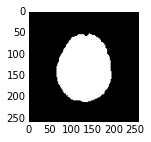

In [112]:
# Now set direction cosign of all images to identity
def ForceDCtoID(inputVolume):
    import os
    import SimpleITK as sitk
    inputVolume.SetDirection((1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0))
    return inputVolume

def ForceOriginToZero(inputVolume):
    import os
    import SimpleITK as sitk
    inputVolume.SetOrigin((0.0, 0.0, 0.0))
    return inputVolume

# mask names
mask1_fn='/Shared/johnsonhj/HDNI/20150319_DWIProcessing/Results/PHD_024/0029/34504/Outputs/BrainMaskForDWI.nrrd'
mask2_fn='/Shared/johnsonhj/HDNI/20150319_DWIProcessing/Results/PHD_024/0029/83611/Outputs/BrainMaskForDWI.nrrd'

mask1 = sitk.ReadImage(mask1_fn)
mask1 = ForceDCtoID(mask1)
mask1 = ForceOriginToZero(mask1)

mask2 = sitk.ReadImage(mask2_fn)
mask2 = ForceDCtoID(mask2)
mask2 = ForceOriginToZero(mask2)

# resample mask2 to mask1
#resFilt = sitk.ResampleImageFilter()
#resFilt.SetReferenceImage(mask1)
#resFilt.SetInterpolator(sitk.sitkNearestNeighbor)
#mask2 = resFilt.Execute(mask2)

mask = sitk.Or(mask1, mask2) # or bitwise of both masks

k = mask.GetSize()[2]/2 # mid-axial slice
mask = mask[:,:,k]

myshow(mask)

In [113]:
# create a  2D scalar distance image
size_x = data1.shape[0] # x_size
size_y = data1.shape[1] # y_size
fa_distance_image = sitk.Image([size_x,size_y], sitk.sitkFloat32)
fa_distance_image.CopyInformation(mask)
md_distance_image = sitk.Image([size_x,size_y], sitk.sitkFloat32)
md_distance_image.CopyInformation(mask)
rd_distance_image = sitk.Image([size_x,size_y], sitk.sitkFloat32)
rd_distance_image.CopyInformation(mask)
ad_distance_image = sitk.Image([size_x,size_y], sitk.sitkFloat32)
ad_distance_image.CopyInformation(mask)
projection_distance_image = sitk.Image([size_x,size_y], sitk.sitkFloat32)
projection_distance_image.CopyInformation(mask)
frobenius_distance_image = sitk.Image([size_x,size_y], sitk.sitkFloat32)
frobenius_distance_image.CopyInformation(mask)

In [114]:
k = data1.shape[2]/2 # mid-axial slice
for i in xrange(data1.shape[0]):
    for j in xrange(data1.shape[1]):
        fa_distance_image[i,j] = abs(tenfit1[i,j,k].fa - tenfit2[i,j,k].fa)
        md_distance_image[i,j] = abs(tenfit1[i,j,k].md - tenfit2[i,j,k].md)
        rd_distance_image[i,j] = abs(tenfit1[i,j,k].rd - tenfit2[i,j,k].rd)
        ad_distance_image[i,j] = abs(tenfit1[i,j,k].ad - tenfit2[i,j,k].ad)
        projection_distance_image[i,j] = projection_metric(tenfit1[i,j,k], tenfit2[i,j,k])
        frobenius_distance_image[i,j] = distance_euclid(tenfit1[i,j,k], tenfit2[i,j,k])

[0.0, 0.0, 0.0] [0, 1, 2]
[0.0, 0.0, 0.0] [0, 1, 2]
[0.0, 0.0, 0.0] [0, 1, 2]
[0.0, 0.0, 0.0] [0, 1, 2]
[0.0, 0.0, 0.0] [0, 1, 2]
[0.0, 0.0, 0.0] [0, 1, 2]
[0.0, 0.0, 0.0] [0, 1, 2]
[0.0, 0.0, 0.0] [0, 1, 2]
[0.0, 0.0, 0.0] [0, 1, 2]
[0.0, 0.0, 0.0] [0, 1, 2]
[0.0, 0.0, 0.0] [0, 1, 2]
[0.0, 0.0, 0.0] [0, 1, 2]
[0.0, 0.0, 0.0] [0, 1, 2]
[0.0, 0.0, 0.0] [0, 1, 2]
[0.0, 0.0, 0.0] [0, 1, 2]
[0.0, 0.0, 0.0] [0, 1, 2]
[0.0, 0.0, 0.0] [0, 1, 2]
[0.0, 0.0, 0.0] [0, 1, 2]
[0.0, 0.0, 0.0] [0, 1, 2]
[0.0, 0.0, 0.0] [0, 1, 2]
[0.0, 0.0, 0.0] [0, 1, 2]
[0.0, 0.0, 0.0] [0, 1, 2]
[0.0, 0.0, 0.0] [0, 1, 2]
[0.0, 0.0, 0.0] [0, 1, 2]
[0.0, 0.0, 0.0] [0, 1, 2]
[0.0, 0.0, 0.0] [0, 1, 2]
[0.0, 0.0, 0.0] [0, 1, 2]
[0.0, 0.0, 0.0] [0, 1, 2]
[0.0, 0.0, 0.0] [0, 1, 2]
[0.0, 0.0, 0.0] [0, 1, 2]
[0.0, 0.0, 0.0] [0, 1, 2]
[0.0, 0.0, 0.0] [0, 1, 2]
[0.0, 0.0, 0.0] [0, 1, 2]
[0.0, 0.0, 0.0] [0, 1, 2]
[0.0, 0.0, 0.0] [0, 1, 2]
[0.0, 0.0, 0.0] [0, 1, 2]
[0.0, 0.0, 0.0] [0, 1, 2]
[0.0, 0.0, 0.0] [0, 1, 2]
[0.0, 0.0, 0

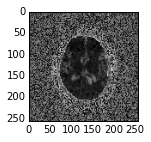

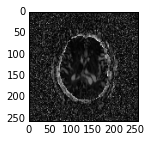

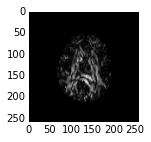

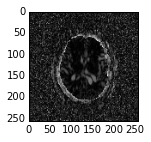

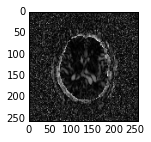

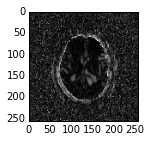

In [117]:
myshow(projection_distance_image)
myshow(frobenius_distance_image)
myshow(fa_distance_image)
myshow(md_distance_image)
myshow(rd_distance_image)
myshow(ad_distance_image)

In [118]:
maskf = sitk.Cast(mask, sitk.sitkFloat32)

fa_distance_image = sitk.Multiply(fa_distance_image,maskf)
md_distance_image = sitk.Multiply(md_distance_image,maskf)
rd_distance_image = sitk.Multiply(rd_distance_image,maskf)
ad_distance_image = sitk.Multiply(ad_distance_image,maskf)
frobenius_distance_image = sitk.Multiply(frobenius_distance_image,maskf)
projection_distance_image = sitk.Multiply(projection_distance_image,maskf)

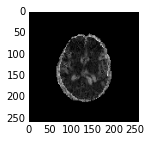

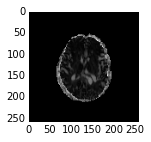

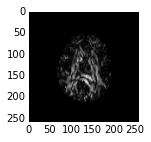

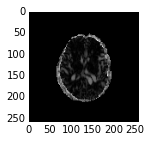

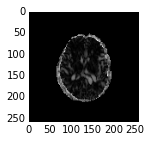

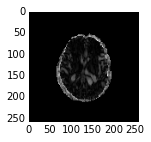

In [119]:
myshow(projection_distance_image)
myshow(frobenius_distance_image)
myshow(fa_distance_image)
myshow(md_distance_image)
myshow(rd_distance_image)
myshow(ad_distance_image)

In [120]:
OUTPUT_DIR='/scratch/TESTS/dti_errors'

fa_distance_arr = sitk.GetArrayFromImage(fa_distance_image)
scipy.io.savemat(os.path.join(OUTPUT_DIR,'FA_distance.mat'), mdict={'inputImage': fa_distance_arr})

md_distance_arr = sitk.GetArrayFromImage(md_distance_image)
scipy.io.savemat(os.path.join(OUTPUT_DIR,'MD_distance.mat'), mdict={'inputImage': md_distance_arr})

rd_distance_arr = sitk.GetArrayFromImage(rd_distance_image)
scipy.io.savemat(os.path.join(OUTPUT_DIR,'RD_distance.mat'), mdict={'inputImage': rd_distance_arr})

ad_distance_arr = sitk.GetArrayFromImage(ad_distance_image)
scipy.io.savemat(os.path.join(OUTPUT_DIR,'AD_distance.mat'), mdict={'inputImage': ad_distance_arr})

projection_distance_arr = sitk.GetArrayFromImage(projection_distance_image)
scipy.io.savemat(os.path.join(OUTPUT_DIR,'projection_distance.mat'), mdict={'inputImage': projection_distance_arr})

# Other metrics

In [157]:
# Log-Euclidian distance
from scipy.linalg import logm

def fro_norm(A,B):
    return np.linalg.norm(A-B, ord='fro')

def distance_logeuclid(tenfit_A, tenfit_B):
    led = fro_norm(logm(tenfit_A.quadratic_form),logm(tenfit_B.quadratic_form))
    #if(led > 4): led = 4
    return led

# Reimannian distance
# eigenvalsh(A,B) is joint eigenvalues of A and B
from scipy.linalg import eigvalsh

def distance_reimann(tenfit_A, tenfit_B):
    rd = np.sqrt((np.log(eigvalsh(tenfit_A.quadratic_form,tenfit_B.quadratic_form))**2).sum())
    #if(rd > 4): rd = 4
    return rd

# Kullback-Leibler distance
def distance_kullback(tenfit_A, tenfit_B):
    A = tenfit_A.quadratic_form
    B = tenfit_B.quadratic_form
    dim = A.shape[0]
    kl = np.sqrt( np.trace( np.dot(np.linalg.inv(A),B)+np.dot(np.linalg.inv(B),A) ) - 2*dim )
    #if( kl > 6 ): kl = 6 
    return 0.5*kl

In [158]:
logeuclid_distance_image = sitk.Image([size_x,size_y], sitk.sitkFloat32)
logeuclid_distance_image.CopyInformation(mask)

reimann_distance_image = sitk.Image([size_x,size_y], sitk.sitkFloat32)
reimann_distance_image.CopyInformation(mask)

kullback_distance_image = sitk.Image([size_x,size_y], sitk.sitkFloat32)
kullback_distance_image.CopyInformation(mask)

In [159]:
def is_pos_def(tenfit_x):
    return np.all(tenfit_x.evals > 0)

In [160]:
count = 0
k = data1.shape[2]/2 # mid-axial slice
for i in xrange(data1.shape[0]):
    for j in xrange(data1.shape[1]):
        if(not is_pos_def(tenfit1[i,j,k]) or not is_pos_def(tenfit2[i,j,k])): count += 1
        logeuclid_distance_image[i,j] = distance_logeuclid(tenfit1[i,j,k], tenfit2[i,j,k])
        reimann_distance_image[i,j] = distance_reimann(tenfit1[i,j,k], tenfit2[i,j,k])
        kullback_distance_image[i,j] = distance_kullback(tenfit1[i,j,k], tenfit2[i,j,k])
print(count)

0


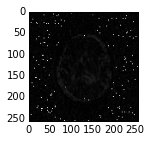

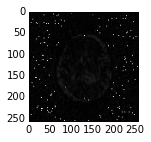

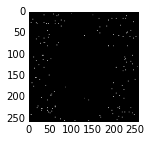

In [161]:
myshow(logeuclid_distance_image)
myshow(reimann_distance_image)
myshow(kullback_distance_image)

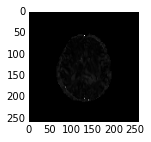

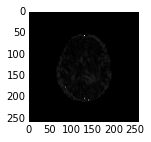

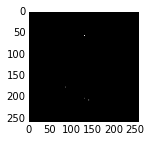

In [162]:
logeuclid_distance_image = sitk.Multiply(logeuclid_distance_image,maskf)
reimann_distance_image = sitk.Multiply(reimann_distance_image,maskf)
kullback_distance_image = sitk.Multiply(kullback_distance_image,maskf)
myshow(logeuclid_distance_image)
myshow(reimann_distance_image)
myshow(kullback_distance_image)

In [176]:
# Now compute the 99 percentile of each image

kullback_distance_arr = sitk.GetArrayFromImage(kullback_distance_image)
print(np.percentile(kullback_distance_arr,99.7))
print(kullback_distance_arr.min())
print(kullback_distance_arr.max())
kullback_distance_arr_clipped = np.clip(kullback_distance_arr, 
                                        kullback_distance_arr.min(),
                                        np.percentile(kullback_distance_arr,99.7))
print(kullback_distance_arr_clipped.min(), kullback_distance_arr_clipped.max())

1.8639079994
0.0
1409.68
0.0 1.86391


In [177]:
kullback_distance_arr = sitk.GetArrayFromImage(kullback_distance_image)
print(kullback_distance_arr.min(), kullback_distance_arr.max())
np.clip(kullback_distance_arr, 
        kullback_distance_arr.min(),
        np.percentile(kullback_distance_arr,99.7),
        kullback_distance_arr)
print(kullback_distance_arr.min(), kullback_distance_arr.max())

0.0 1409.68
0.0 1.86391


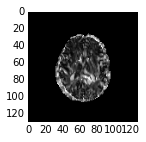

In [178]:
kullback_distance_image = sitk.GetImageFromArray(kullback_distance_arr)
myshow(kullback_distance_image)

In [173]:
# clip images within 3 std
# 1) find mean and std within mask
lstatfilt = sitk.LabelStatisticsImageFilter()
lstatfilt.Execute(kullback_distance_image,mask)
mean = lstatfilt.GetMean(1)
std = lstatfilt.GetSigma(1)
print(mean, std)

1.48226327438 31.5809661814


In [174]:
logeuclid_distance_arr = sitk.GetArrayFromImage(logeuclid_distance_image)
scipy.io.savemat(os.path.join(OUTPUT_DIR,'logeuclid_distance.mat'), mdict={'inputImage': logeuclid_distance_arr})

reimann_distance_arr = sitk.GetArrayFromImage(reimann_distance_image)
scipy.io.savemat(os.path.join(OUTPUT_DIR,'reimann_distance.mat'), mdict={'inputImage': reimann_distance_arr})

kullback_distance_arr = sitk.GetArrayFromImage(kullback_distance_image)
scipy.io.savemat(os.path.join(OUTPUT_DIR,'kullback_distance.mat'), mdict={'inputImage': kullback_distance_arr})

In [104]:
print(kullback_distance_arr[88,42])

0.0


In [86]:
distance_kullback(tenfit1[42,88,35],tenfit2[42,88,35])

646.34164020190531

In [87]:
# 69,103,35
print(tenfit1[42,88,35].quadratic_form)
print(tenfit1[42,88,35].evecs)
print(tenfit1[42,88,35].evals)
print('----')
print(tenfit2[42,88,35].quadratic_form)
print(tenfit2[42,88,35].evecs)
print(tenfit2[42,88,35].evals)

[[  4.50743507e-06  -1.37580069e-06   1.32509012e-05]
 [ -1.37580069e-06   7.01845528e-05  -5.56052698e-05]
 [  1.32509012e-05  -5.56052698e-05   7.70705167e-05]]
[[ 0.08437389  0.40779204  0.90916813]
 [-0.67803512  0.69210426 -0.24750774]
 [ 0.73017082  0.59556473 -0.33489285]]
[  1.30236645e-04   2.15248635e-05   9.96015936e-10]
----
[[  1.65743459e-03  -1.54321953e-05  -7.40929080e-06]
 [ -1.54321953e-05   1.63698425e-03  -1.18819433e-07]
 [ -7.40929080e-06  -1.18819433e-07   1.62775658e-03]]
[[-0.87622834  0.27853868 -0.39324305]
 [ 0.45280869  0.75511302 -0.47409769]
 [ 0.16488841 -0.5934817  -0.78777616]]
[ 0.0016668   0.00163139  0.00162399]


In [ ]:
kl = np.sqrt( np.trace( np.dot(np.linalg.inv(A),B)+np.dot(np.linalg.inv(B),A) ) - 2*dim )

In [88]:
A = tenfit1[42,88,35].quadratic_form
B = tenfit2[42,88,35].quadratic_form
print(np.linalg.inv(A))
np.dot(np.linalg.inv(A),B)

[[  8.29900825e+08  -2.25913579e+08  -3.05680050e+08]
 [ -2.25913579e+08   6.15309038e+07   8.32354745e+07]
 [ -3.05680050e+08   8.32354745e+07   1.12622408e+08]]


array([[ 1381257.54907082,  -382587.84290439,  -503694.84713042],
       [ -376003.25366538,   104201.57310837,   137153.63999611],
       [ -508763.6467561 ,   140959.09371703,   185576.84826052]])

In [66]:
A = np.matrix([[9.96e-10, 0, 0],[0, 9.96e-10, 0],[0, 0, 9.96e-10]])
print(A)
np.linalg.inv(A)

[[  9.96000000e-10   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   9.96000000e-10   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   9.96000000e-10]]


matrix([[  1.00401606e+09,   0.00000000e+00,   0.00000000e+00],
        [  0.00000000e+00,   1.00401606e+09,   0.00000000e+00],
        [  0.00000000e+00,   0.00000000e+00,   1.00401606e+09]])

In [89]:
np.dot(np.linalg.inv(A),B)

array([[ 1381257.54907082,  -382587.84290439,  -503694.84713042],
       [ -376003.25366538,   104201.57310837,   137153.63999611],
       [ -508763.6467561 ,   140959.09371703,   185576.84826052]])

In [90]:
kl = np.sqrt( np.trace( np.dot(np.linalg.inv(A),A)+np.dot(np.linalg.inv(A),A) ) - 2*3 )
print(kl)

1.34869915235e-06


In [91]:
np.dot(np.linalg.inv(A),A)

array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [ -2.27373675e-13,   1.00000000e+00,  -9.09494702e-13],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00]])

In [92]:
np.dot(np.linalg.inv(B),A)

array([[ 0.00274839, -0.00058366,  0.00789109],
       [-0.00081395,  0.04286632, -0.03389029],
       [ 0.00815304, -0.03416021,  0.04738114]])

In [93]:
np.dot(np.linalg.inv(A),B)+np.dot(np.linalg.inv(B),A)

array([[ 1381257.55181921,  -382587.84348805,  -503694.83923933],
       [ -376003.25447933,   104201.61597469,   137153.60610582],
       [ -508763.63860306,   140959.05955682,   185576.89564165]])

In [96]:
np.linalg.det(B)

4.4159423601160817e-09

# Display ODFs

In [ ]:
print('Computing tensor ellipsoids in a part of image')

from dipy.data import get_sphere
sphere = get_sphere('symmetric724')

from dipy.viz import fvtk
ren = fvtk.ren()

evals = tenfit1.evals[45:48, 50:53, 35:36]
evecs = tenfit1.evecs[45:48, 50:53, 35:36]

cfa = cfa1[45:48, 50:53, 35:36]
cfa /= cfa.max() 

fvtk.add(ren, fvtk.tensor(evals, evecs, cfa, sphere))
print('Saving illustration as tensor_ellipsoids1.png')
fvtk.record(ren, n_frames=1, out_path=os.path.join(OUTPUT_DIR,'tensor_ellipsoids1.png'), size=(600, 600))

tensor_img1 = sitk.ReadImage(os.path.join(OUTPUT_DIR,'tensor_ellipsoids1.png'))
myshow(tensor_img1)

In [ ]:
fvtk.clear(ren)

evals = tenfit2.evals[45:48, 50:53, 35:36]
evecs = tenfit2.evecs[45:48, 50:53, 35:36]

cfa = cfa2[45:48, 50:53, 35:36]
cfa /= cfa.max() 

fvtk.add(ren, fvtk.tensor(evals, evecs, cfa, sphere))
fvtk.record(ren, n_frames=1, out_path=os.path.join(OUTPUT_DIR,'tensor_ellipsoids2.png'), size=(600, 600))

tensor_img2 = sitk.ReadImage(os.path.join(OUTPUT_DIR,'tensor_ellipsoids2.png'))
myshow(tensor_img2)

In [ ]:
projection_distance_arr_crop = projection_distance_arr[50:53, 45:48]
scipy.io.savemat(os.path.join(OUTPUT_DIR,'projection_distance_crop.mat'), mdict={'inputImage': projection_distance_arr_crop})

In [ ]:
print(projection_distance_arr_crop)

In [ ]:
projection_metric(tenfit1[46,51,35],tenfit2[46,51,35])

In [ ]:
fvtk.clear(ren)

cfa = cfa1[45:48, 50:53, 35:36]
cfa /= cfa.max() 

tensor_odfs = tenfit1[45:48, 50:53, 35:36].odf(sphere)

fvtk.add(ren, fvtk.sphere_funcs(tensor_odfs, sphere, cfa))
fvtk.record(ren, n_frames=1, out_path=os.path.join(OUTPUT_DIR,'tensor_odfs1.png'), size=(600, 600))

odf_img1 = sitk.ReadImage(os.path.join(OUTPUT_DIR,'tensor_odfs1.png'))
myshow(odf_img1)

In [ ]:
fvtk.clear(ren)

cfa = cfa2[45:48, 50:53, 35:36]
cfa /= cfa.max() 

tensor_odfs = tenfit2[45:48, 50:53, 35:36].odf(sphere)

fvtk.add(ren, fvtk.sphere_funcs(tensor_odfs, sphere, cfa2))
fvtk.record(ren, n_frames=1, out_path=os.path.join(OUTPUT_DIR,'tensor_odfs2.png'), size=(600, 600))

odf_img2 = sitk.ReadImage(os.path.join(OUTPUT_DIR,'tensor_odfs2.png'))
myshow(odf_img2)

In [ ]:
print(tenfit1[46,51,35].lower_triangular())
print(tenfit2[46,51,35].lower_triangular())

In [ ]:
print(tenfit1[46,52,35].lower_triangular())
print(tenfit2[46,52,35].lower_triangular())